***
## notebook config

In [1]:
ON_COLAB = False
ASSESS = True

In [2]:
if ON_COLAB:
    from google.colab import drive
    from google.colab import files
    drive.mount('/content/drive', force_remount=True)
    
    !pip install --upgrade kaggle > /dev/null 2>&1
    !mkdir -p ~/.kaggle/ && cp /content/drive/MyDrive/kaggle/kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json
    
    !free -h
    
    !pip install --upgrade category_encoders > /dev/null 2>&1
    !pip install --upgrade tsforest > /dev/null 2>&1
    !pip install --upgrade lightgbm > /dev/null 2>&1
    !pip install --upgrade optuna > /dev/null 2>&1

In [3]:
if ON_COLAB:
    !kaggle datasets download -d mavillan/meli-2021 --force --unzip
    !ls -halt
    input_path = "./"
    print("input_path:", input_path)
    subs_path = "/content/drive/MyDrive/meli2021/subs"
    print("subs_path:", subs_path)
    results_path = "/content/drive/MyDrive/meli2021/results"
    print("results_path:", results_path)
else:
    input_path = "../data"
    print("input_path:", input_path)
    subs_path = "../subs"
    print("subs_path:", subs_path)
    results_path = "../results"
    print("results_path:", results_path)

input_path: ../data
subs_path: ../subs
results_path: ../results


***

In [4]:
from copy import deepcopy
import gc
import dill
from glob import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import time
from tqdm import tqdm
import yaml
import shap

import category_encoders as ce
import lightgbm as lgb
from tsforest.forecast import LightGBMForecaster

import sys
sys.path.append("../utils")
from memory import reduce_mem_usage
from metrics import RMSSE, ranked_probability_score, scoring_function, binarize_predictions
from inventory import InventoryDaysPredictor
from features import Featurador


In [5]:
SEED = 19
SUB_NBR = str(max([int(fn.split("/")[-1].split(".")[0][3:]) for fn in glob(f"{subs_path}/*")])+1)
print(SUB_NBR)

18


In [6]:
np.random.seed(SEED)
pd.set_option('display.max_columns', None)

***
## loading data for assessment

In [7]:
with open(f"../data/skus_assess_m1.yaml", "r") as file:
    skus_assess_m1 = yaml.load(file, Loader=yaml.FullLoader)
    print(f"len(skus_assess_m1): {len(skus_assess_m1)}")
    file.close()

with open(f"../data/skus_assess_m2.yaml", "r") as file:
    skus_assess_m2 = yaml.load(file, Loader=yaml.FullLoader)
    print(f"len(skus_assess_m2): {len(skus_assess_m2)}")
    file.close()
    
skus_for_test = pd.read_csv(f"{input_path}/test_data.csv").sku.values
print(f"len(skus_for_test): {len(skus_for_test)}")

len(skus_assess_m1): 482635
len(skus_assess_m2): 272130
len(skus_for_test): 551472


In [8]:
if ASSESS:
    scales = pd.read_csv(f"{input_path}/scales.csv")
    
    #skus_assess_m1 = set(skus_assess_m1) & set(skus_for_test)
    #print("# skus assess & test:", len(skus_assess_m1))

    dataset = (
        pd.read_parquet(f"{input_path}/train-m1.parquet")
        .query("sku in @skus_assess_m1")
        .rename({"date":"ds", "sold_quantity":"y"}, axis=1,)
        .sort_values(["sku","ds"])
        .reset_index(drop=True)
    )
    
    with open("../encoders/encoder-stg1.dill", "rb") as file:
        encoder = dill.load(file)
        file.close()
    
    transformed = encoder.transform(dataset[encoder.cols].astype("category"))
    for col in transformed.columns:
        dataset[col+"_glm"] = transformed[col].values

In [9]:
if ASSESS:
    raw = pd.read_parquet(f"{input_path}/train_data.parquet", columns=["sku", "date", "sold_quantity", "minutes_active"])
    metadata = pd.read_csv(f"{input_path}/metadata.csv", usecols=["sku","item_domain_id","site_id"])
    raw = pd.merge(raw, metadata, how="inner", on="sku")

    # compute q_mean and q_std features (w/o leakage)
    feat = Featurador(raw)
    feat.fit(left_limit="2021-02-01", right_limit="2021-03-01")
    dataset = feat.transform(dataset)

In [10]:
#with open(f"../config/dist_hparams.yml", "r") as file:
#    dist_config = yaml.load(file, Loader=yaml.FullLoader)
#    file.close()
    
# use dist_config of best submission
dist_config = dict(
    beta = 0.634505,
    lambda1 = 0.458712,
    lambda2 = 0.967726,
)
print(dist_config)

{'beta': 0.634505, 'lambda1': 0.458712, 'lambda2': 0.967726}


***
## model config

In [11]:
categorical_features = {
    #"sku": ("y", ce.CatBoostEncoder, None),
    "currency": "default",
    "listing_type": "default",
    "shipping_logistic_type": "default",
    "shipping_payment": "default",
    "item_domain_id": "default",
    #"item_id": ("y", ce.CatBoostEncoder, None),
    "site_id":"default",
    "product_id": "default",
    "product_family_id": "default",
}

exclude_features = ["fold","sold_quantity","sku","item_id","minutes_active",]

model_params = {
    'objective':'tweedie',
    'tweedie_variance_power':1.6,
    'metric':'None',
    'num_iterations':1000,
    'max_bin': 63,
    'bin_construct_sample_cnt':20000000,
    'num_leaves': 2**8-1,
    'min_data_in_leaf': 2**8-1,
    'learning_rate': 0.02,
    'max_delta_step':1.,
    'feature_fraction':0.8,
    'bagging_fraction':0.8,
    'bagging_freq':1,
    'lambda_l2':0.1,
    'max_cat_threshold': 64,
    'cat_l2': 50,
    'cat_smooth': 50,
    'boost_from_average': False,
    'force_row_wise': True,
    'deterministic':True,
    'seed':SEED,
}
time_features = [
    "week_day",
    "week_day_cos",
    "week_day_sin",
    "month_progress",
]
model_kwargs = {
    "model_params":model_params,
    "time_features":time_features,
    "exclude_features":exclude_features,
    "categorical_features":categorical_features,
    "ts_uid_columns":["sku",],
    "lags": [1,],
    "window_functions":{
        "mean":   (None, [1,], [3,7,]),
        "std":    (None, [1,], [3,7]),
    },
}

***
## model training: assessment

------------------------------------------------------------------------------------------
Preparing model for site: MLA
Mem. usage decreased to 129.21 Mb (50.9% reduction)
Mem. usage decreased to 134.63 Mb (50.9% reduction)
Elapsed time for processing features: 0.5567625800768534 min.
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Info] Total Bins 10410
[LightGBM] [Info] Number of data points in the train set: 1209701, number of used features: 23
Training until validation scores don't improve for 30 rounds
[50]	valid_0's rmsse: 0.817825
[100]	valid_0's rmsse: 0.782234
[150]	valid_0's rmsse: 0.778623
Early stopping, best iteration is:
[158]	valid_0's rmsse: 0.778435


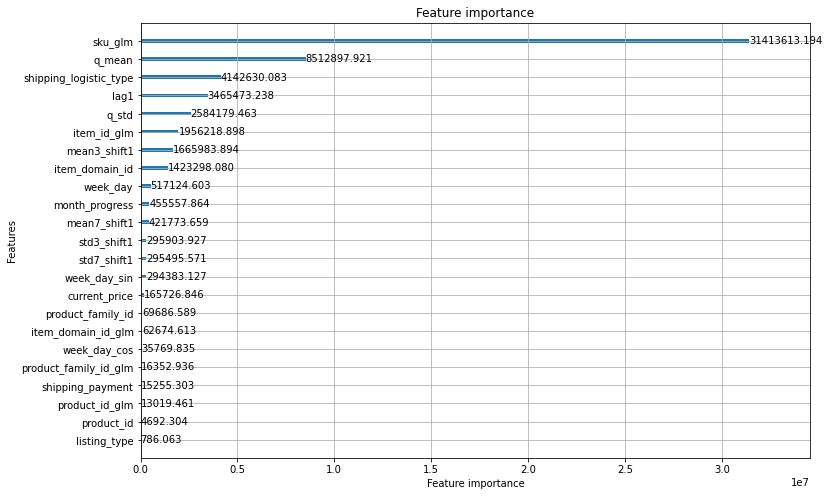

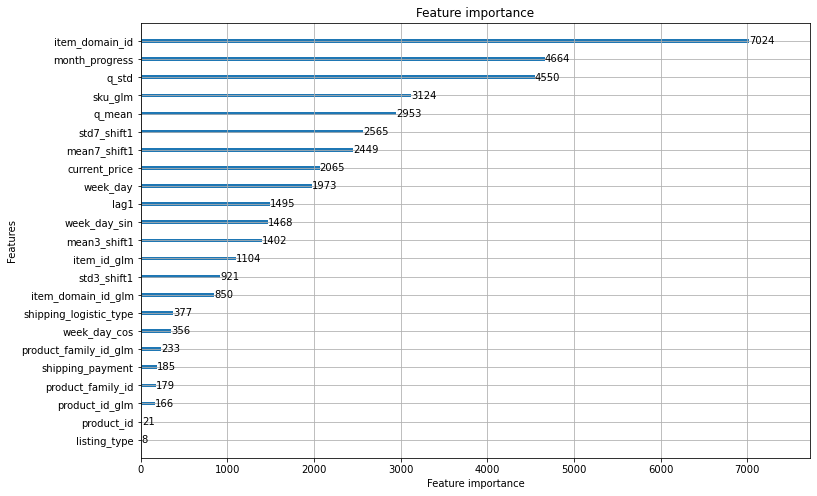

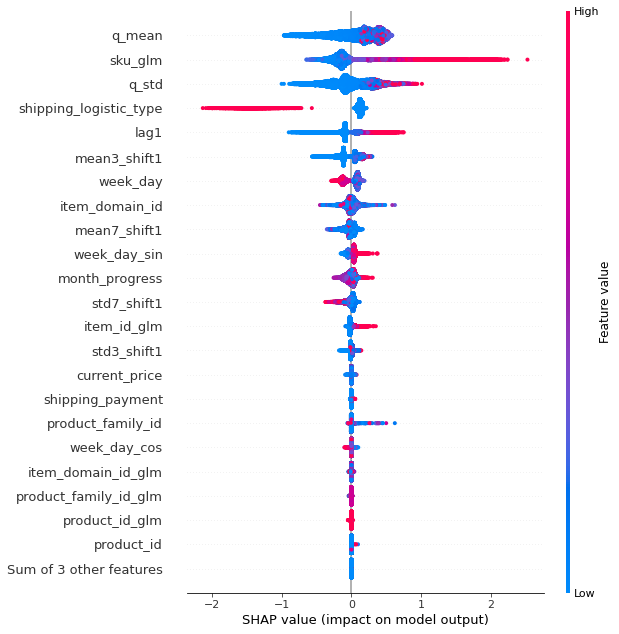

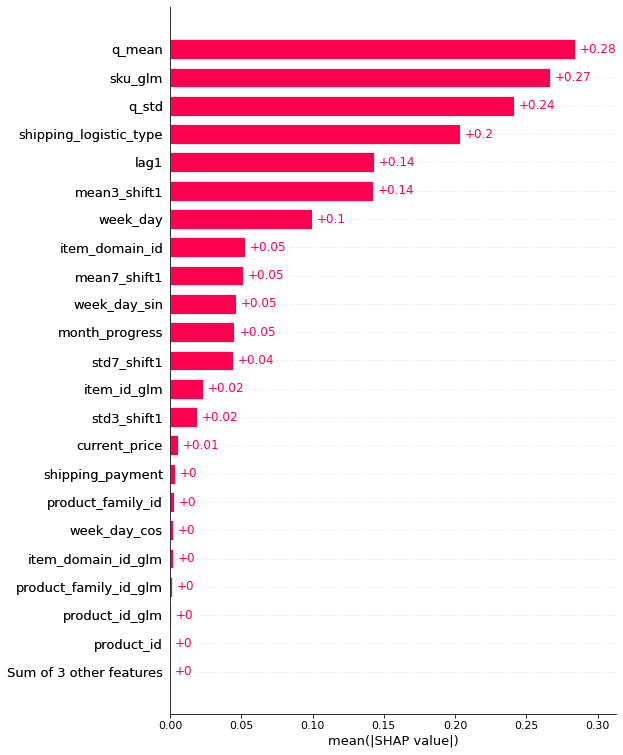

Elapsed time for training the model: 1.5611705382664998 min.
------------------------------------------------------------------------------------------
Preparing model for site: MLB
Mem. usage decreased to 754.74 Mb (50.9% reduction)
Mem. usage decreased to 785.20 Mb (50.9% reduction)
Elapsed time for processing features: 3.0893010894457498 min.
[LightGBM] [Info] Total Bins 17065
[LightGBM] [Info] Number of data points in the train set: 7066070, number of used features: 23
Training until validation scores don't improve for 30 rounds
[50]	valid_0's rmsse: 0.860012
[100]	valid_0's rmsse: 0.820084
[150]	valid_0's rmsse: 0.814405
[200]	valid_0's rmsse: 0.813294
Early stopping, best iteration is:
[212]	valid_0's rmsse: 0.813208


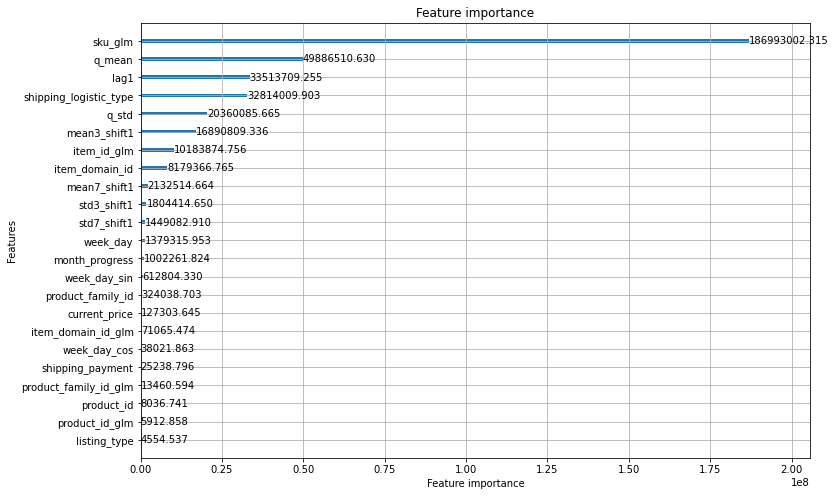

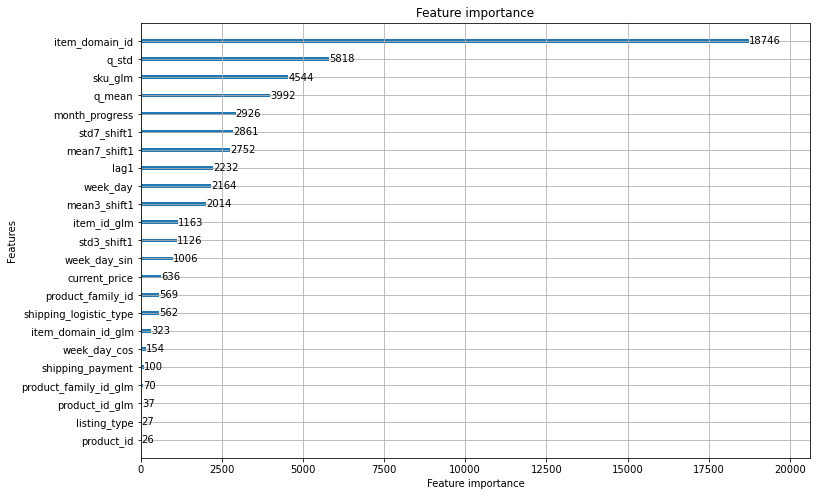

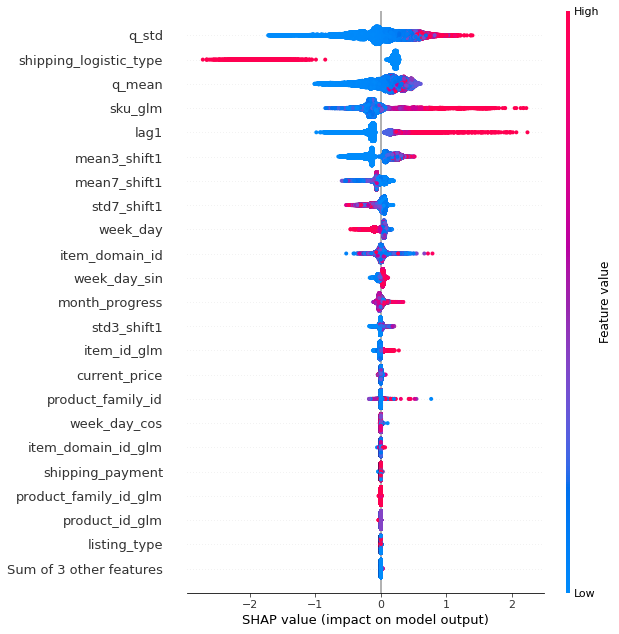

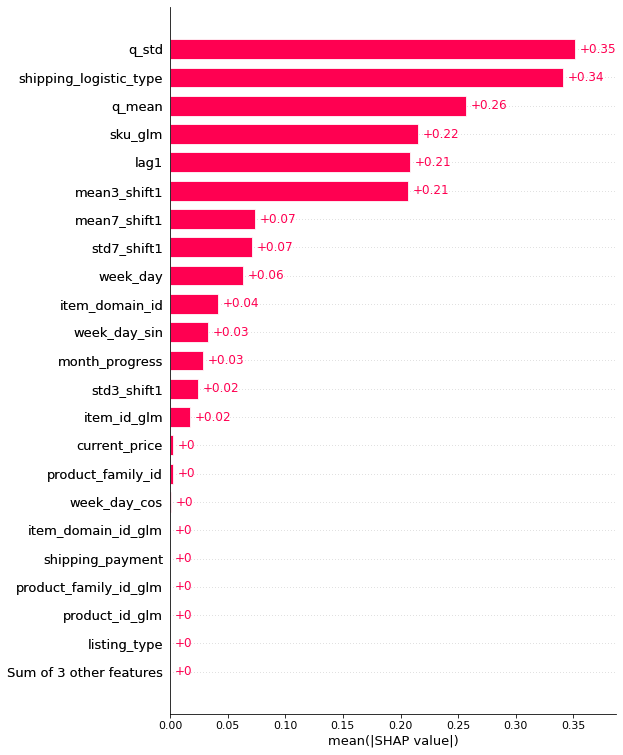

Elapsed time for training the model: 3.7942696611086526 min.
------------------------------------------------------------------------------------------
Preparing model for site: MLM
Mem. usage decreased to 600.07 Mb (50.9% reduction)
Mem. usage decreased to 626.70 Mb (50.9% reduction)
Elapsed time for processing features: 2.5416854063669843 min.
[LightGBM] [Info] Total Bins 15069
[LightGBM] [Info] Number of data points in the train set: 5618024, number of used features: 23
Training until validation scores don't improve for 30 rounds
[50]	valid_0's rmsse: 0.817162
[100]	valid_0's rmsse: 0.778034
[150]	valid_0's rmsse: 0.772347
[200]	valid_0's rmsse: 0.77168
Early stopping, best iteration is:
[190]	valid_0's rmsse: 0.771574


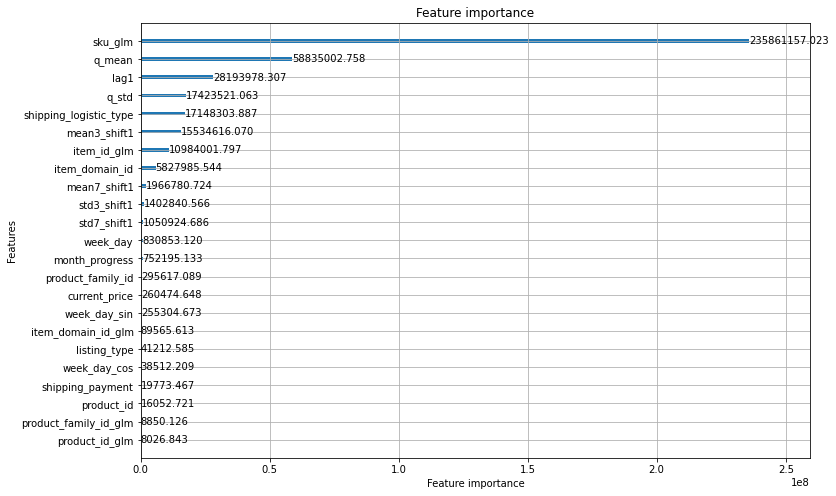

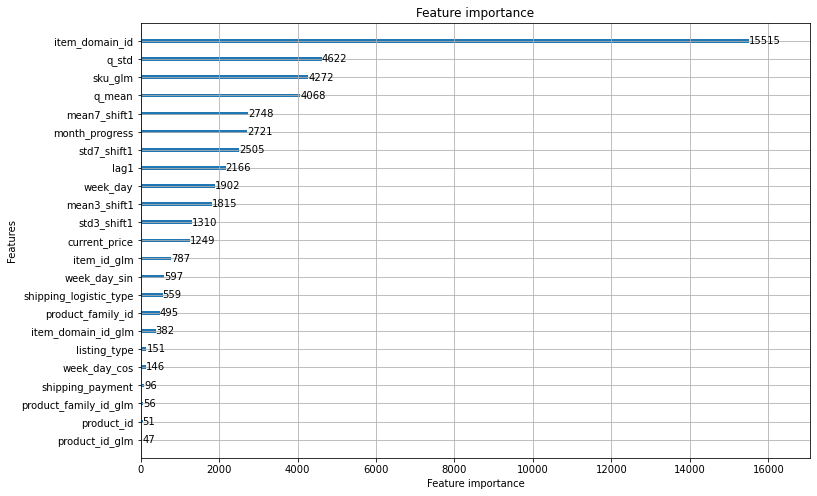

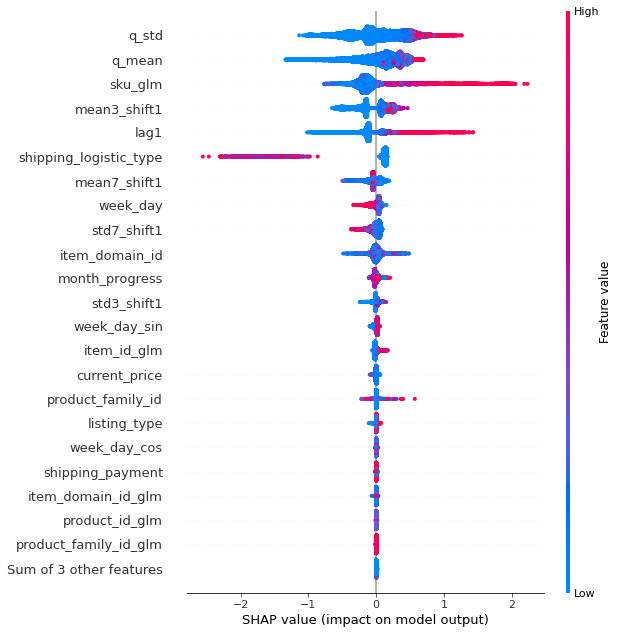

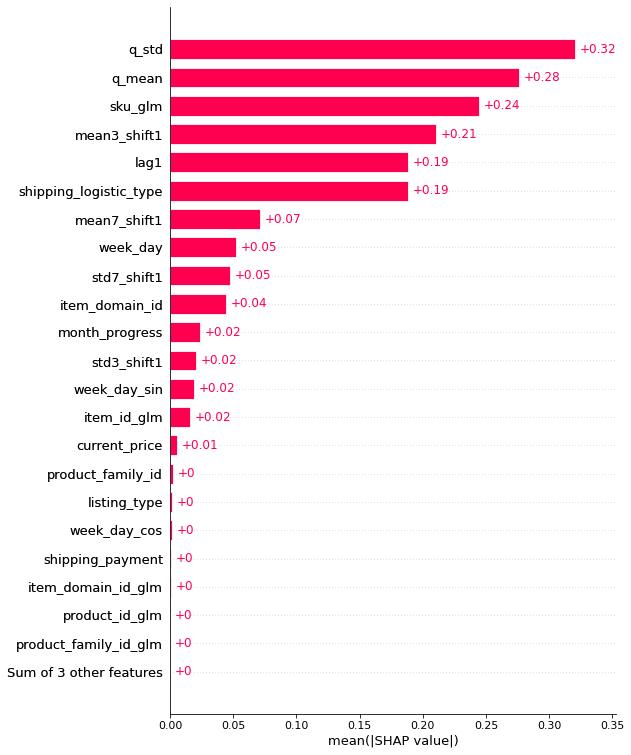

Elapsed time for training the model: 2.9654560486475625 min.


{'rmsse_MLA': 0.778434532475801,
 'rmsse_MLB': 0.8132077403327754,
 'rmsse_MLM': 0.7715735506526289,
 'rmsse_AVG': 0.7877386078204017}

In [12]:
if ASSESS:
    models_by_site = list()
    sites = ["MLA","MLB","MLM"]

    for site in sites:
        print("-"*90)
        print(f"Preparing model for site: {site}")

        tic = time.time()
        train_data = dataset.query("site_id == @site").reset_index(drop=True)
        valid_idx = train_data.query("ds > '2021-03-01'").index

        model = LightGBMForecaster(**model_kwargs)
        model.prepare_features(train_data, valid_idx)
        model.train_features = reduce_mem_usage(model.train_features, verbose=True)
        model.valid_features = reduce_mem_usage(model.valid_features, verbose=True)
        gc.collect()
        tac = time.time()
        print(f"Elapsed time for processing features: {(tac-tic)/60} min.")

        tic = time.time()
        evaluator = RMSSE(train_data.loc[valid_idx, ["sku","y"]], scales)
        model.fit(fit_kwargs={"verbose_eval":50, "feval":evaluator.evaluate})
        
        lgb.plot_importance(model.model.model, figsize=(12,8), importance_type="gain")
        lgb.plot_importance(model.model.model, figsize=(12,8), importance_type="split")
        plt.show()
        explainer = shap.Explainer(model.model.model)
        shap_values = explainer(model.valid_features[model.input_features].sample(30000))
        shap.plots.beeswarm(shap_values, max_display=23, show=True)
        shap.plots.bar(shap_values, max_display=23, show=True)

        models_by_site.append(model)
        tac = time.time()
        print(f"Elapsed time for training the model: {(tac-tic)/60} min.")
        
    errors = list()
    sites = ["MLA","MLB","MLM"]
    for site,model in zip(sites,models_by_site):
        error = model.model.model.best_score["valid_0"]["rmsse"]
        errors.append(error)
    result = {
        "rmsse_MLA":errors[0], 
        "rmsse_MLB":errors[1],
        "rmsse_MLM":errors[2],
        "rmsse_AVG":np.mean(errors),
    }
    display(result)


In [13]:
if ASSESS:
    # calculates fit stats on train dataset
    all_preds = list()
    for site,model in zip(sites,models_by_site):
        preds = model.predict(dataset.query("site_id==@site & ds<='2021-03-01'"))
        all_preds.append(preds)
    train_preds = pd.concat(all_preds, axis=0, ignore_index=True)
    train_preds = pd.merge(train_preds, dataset.loc[:,["ds","sku","site_id","y"]], how="inner", on=["ds","sku"])
    
    train_preds["abs_error"] = train_preds.eval("abs(y-y_pred)")
    train_preds["sq_error"] = train_preds.eval("(y-y_pred)**2")
    train_preds["residual"] = train_preds.eval("(y-y_pred)")

    rmse = np.sqrt(train_preds.groupby(["sku"])["sq_error"].mean()).reset_index(name="rmse")
    mean_ae = train_preds.groupby(["sku"])["abs_error"].mean().reset_index(name="mean_ae")
    median_ae = train_preds.groupby(["sku"])["abs_error"].median().reset_index(name="median_ae")
    residual_std = train_preds.groupby(["sku"])["residual"].std().reset_index(name="residual_std")
    residual_mad = train_preds.groupby(["sku"])["residual"].mad().reset_index(name="residual_mad")

    fit_stats = (
        rmse
        .merge(mean_ae, how="inner", on="sku")
        .merge(median_ae, how="inner", on="sku")
        .merge(residual_std, how="inner", on="sku")
        .merge(residual_mad, how="inner", on="sku")
        .merge(scales, how="inner", on="sku")
        .merge(dataset[["sku","site_id","q_mean"]].drop_duplicates(subset=["sku"]), how="inner", on="sku")
    )
    fit_stats["rmsse"] = fit_stats.eval("rmse / scale")
    fit_stats["rmse_norm"] = fit_stats.eval("rmse / q_mean")
    fit_stats["mean_ae_norm"] = fit_stats.eval("mean_ae / q_mean")
    fit_stats["median_ae_norm"] = fit_stats.eval("median_ae / q_mean")
    fit_stats["residual_std_norm"] = fit_stats.eval("residual_std / q_mean")
    fit_stats["residual_mad_norm"] = fit_stats.eval("residual_mad / q_mean")
    fit_stats["scale_norm"] = fit_stats.eval("scale / q_mean")
    display(fit_stats.groupby("site_id")["rmsse"].mean())

site_id
MLA    0.734851
MLB    0.757349
MLM    0.794119
Name: rmsse, dtype: float64

In [14]:
%%time
if ASSESS:
    all_preds = list()
    for site,model in zip(sites,models_by_site):
        print("Preds for site:", site)
        preds = model.predict(dataset.query("site_id==@site & ds>'2021-03-01'"), recursive=True)
        all_preds.append(preds)
    oof = pd.concat(all_preds, axis=0, ignore_index=True)

Preds for site: MLA
Preds for site: MLB
Preds for site: MLM
CPU times: user 10min 3s, sys: 24.4 s, total: 10min 27s
Wall time: 27min 2s


In [15]:
if ASSESS:
    mrg = pd.merge(oof, dataset.loc[:,["ds","sku","site_id","y"]], how="inner", on=["ds","sku"])
    mrg["sq_error"] = mrg.eval("(y-y_pred)**2")
    valid_errors = np.sqrt(mrg.groupby(["sku","site_id"])["sq_error"].mean()).reset_index(name="rmse")
    valid_errors = pd.merge(valid_errors, scales, how="inner", on="sku")
    valid_errors["rmsse"] = valid_errors.eval("rmse/scale")
    display(valid_errors.groupby("site_id")["rmsse"].mean())

site_id
MLA    0.841089
MLB    0.916399
MLM    0.892017
Name: rmsse, dtype: float64

In [16]:
if ASSESS:
    oof.to_csv(f"{results_path}/oof_preds_lgbm-m1.csv", index=False)
    fit_stats.to_csv(f"{results_path}/train_errors_lgbm-m1-stg1.csv", index=False)

***
## Assessment of invetory days prediction

In [17]:
if ASSESS:
    if "oof" not in locals():
        oof = pd.read_csv("../results/oof_preds_lgbm-m1.csv")
        
    predictor = InventoryDaysPredictor(dataset.query("ds <= '2021-03-01'"))
    predictor.fit(oof)

100%|██████████| 482635/482635 [01:11<00:00, 6790.79it/s]


In [18]:
if ASSESS:
    valid = (
        pd.read_csv(f"{input_path}/validation_seed2_harder.csv")
        .query("sku in @skus_assess_m1")
        .reset_index(drop=True)
    )

    preds = list()
    for sku,df in tqdm(valid.groupby("sku")):
        preds.append(predictor.predict(sku, df.target_stock.values[0])[0])
        
    valid["days_to_stockout"] = np.asarray(preds)
    valid["days_to_stockout_disc"] = valid["days_to_stockout"].astype(int)

100%|██████████| 482635/482635 [01:11<00:00, 6720.74it/s]


RMSE (mean):  10.043676218211898
MAE (mean):  7.466828236013578
MAE (median):  5.426278438806991



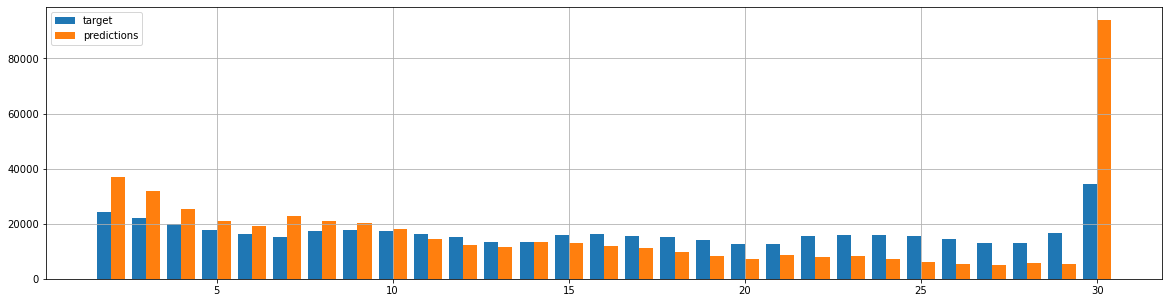

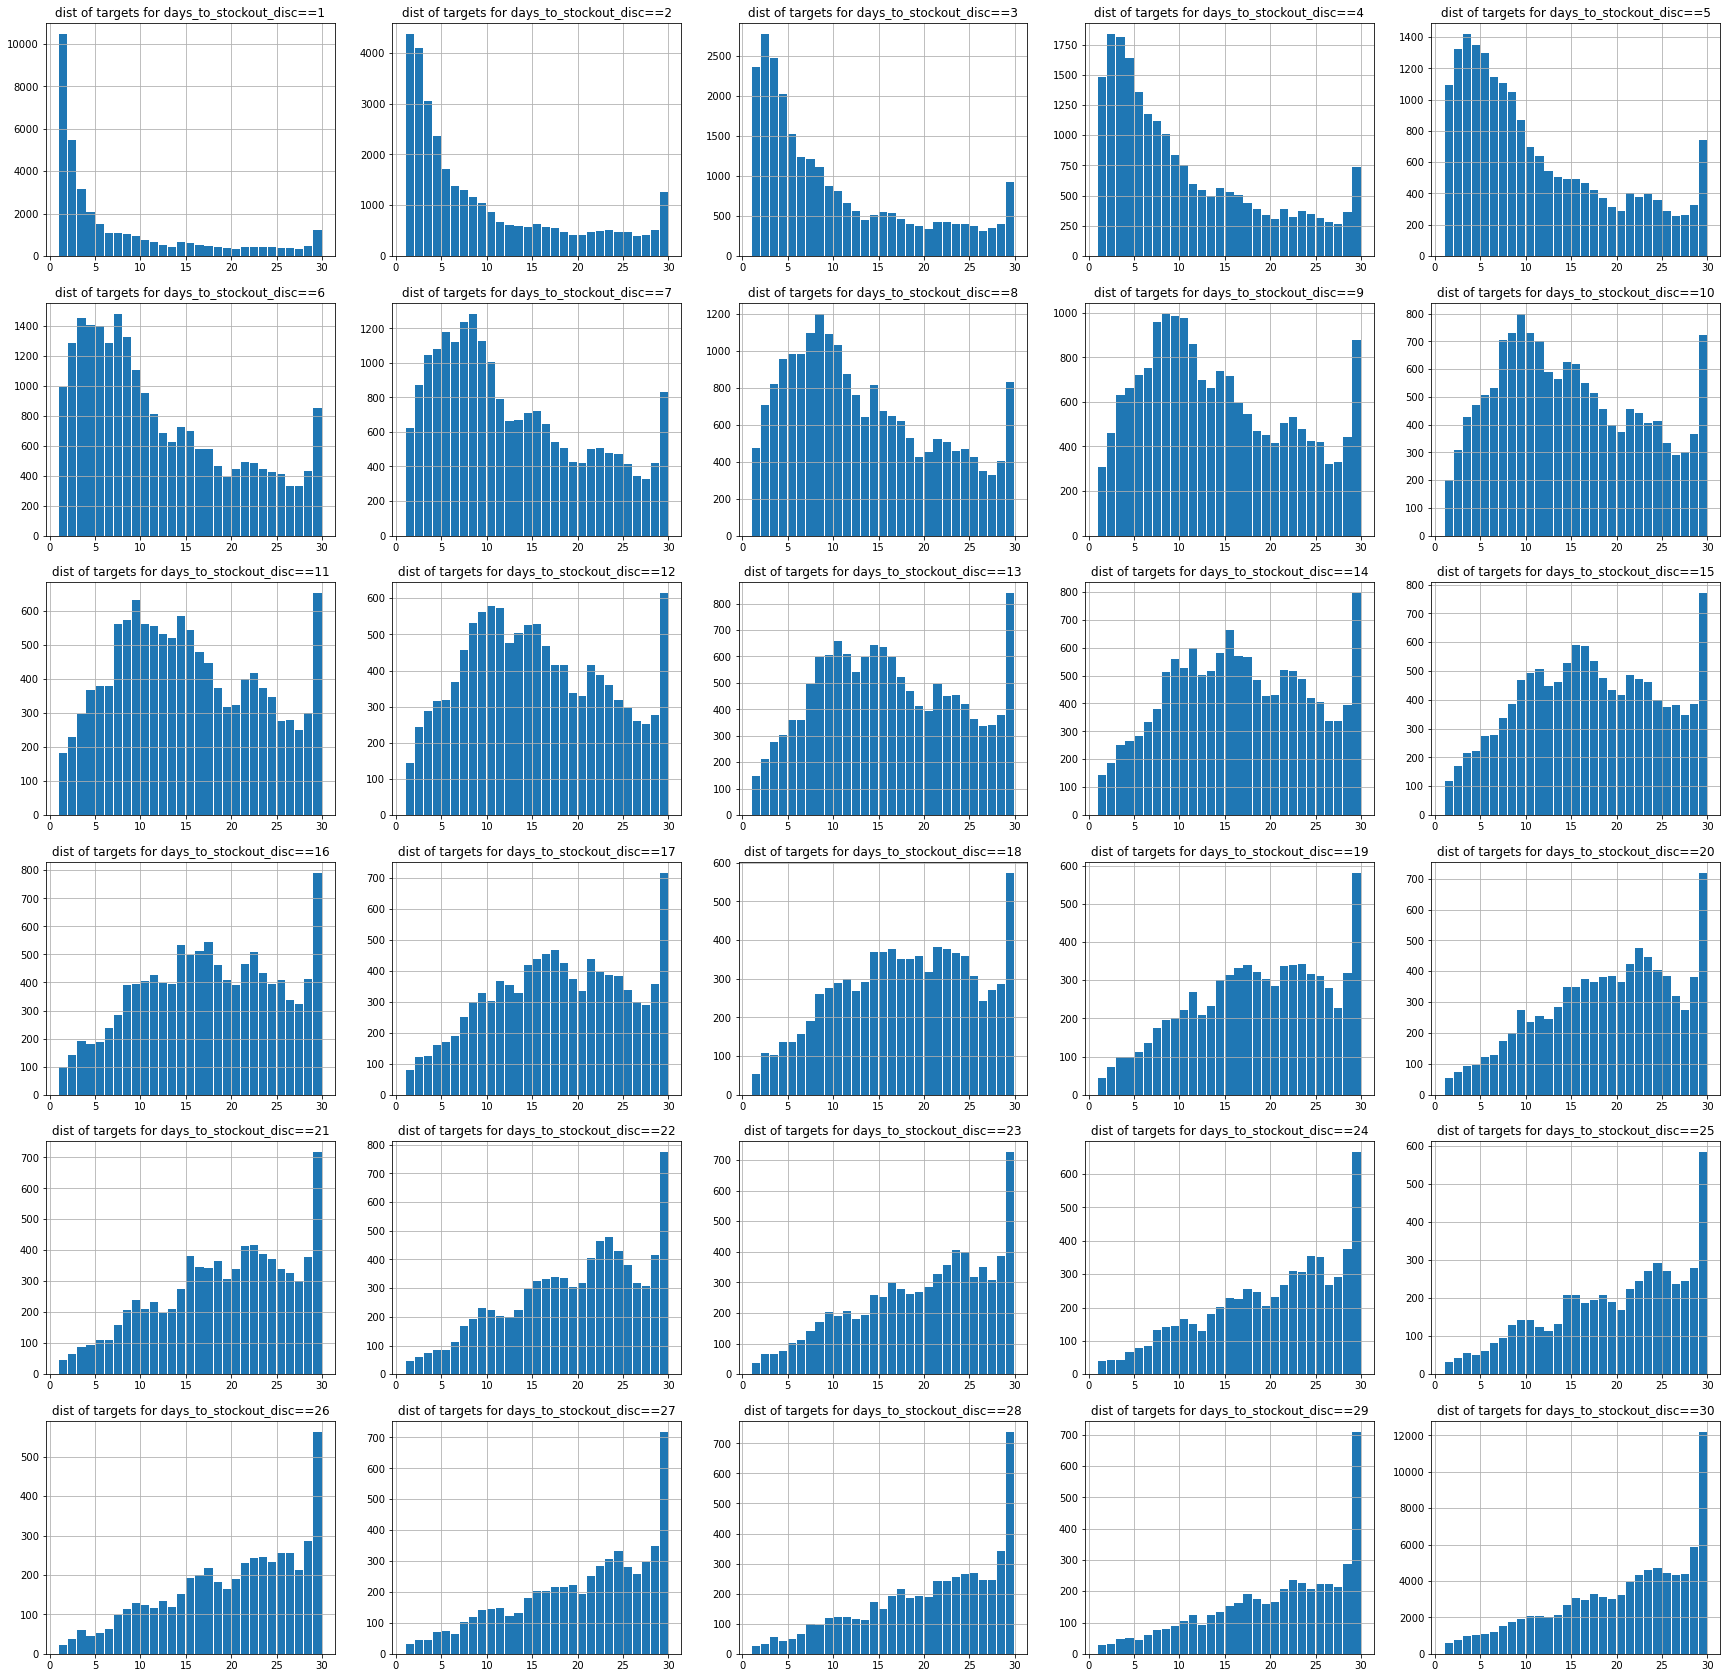

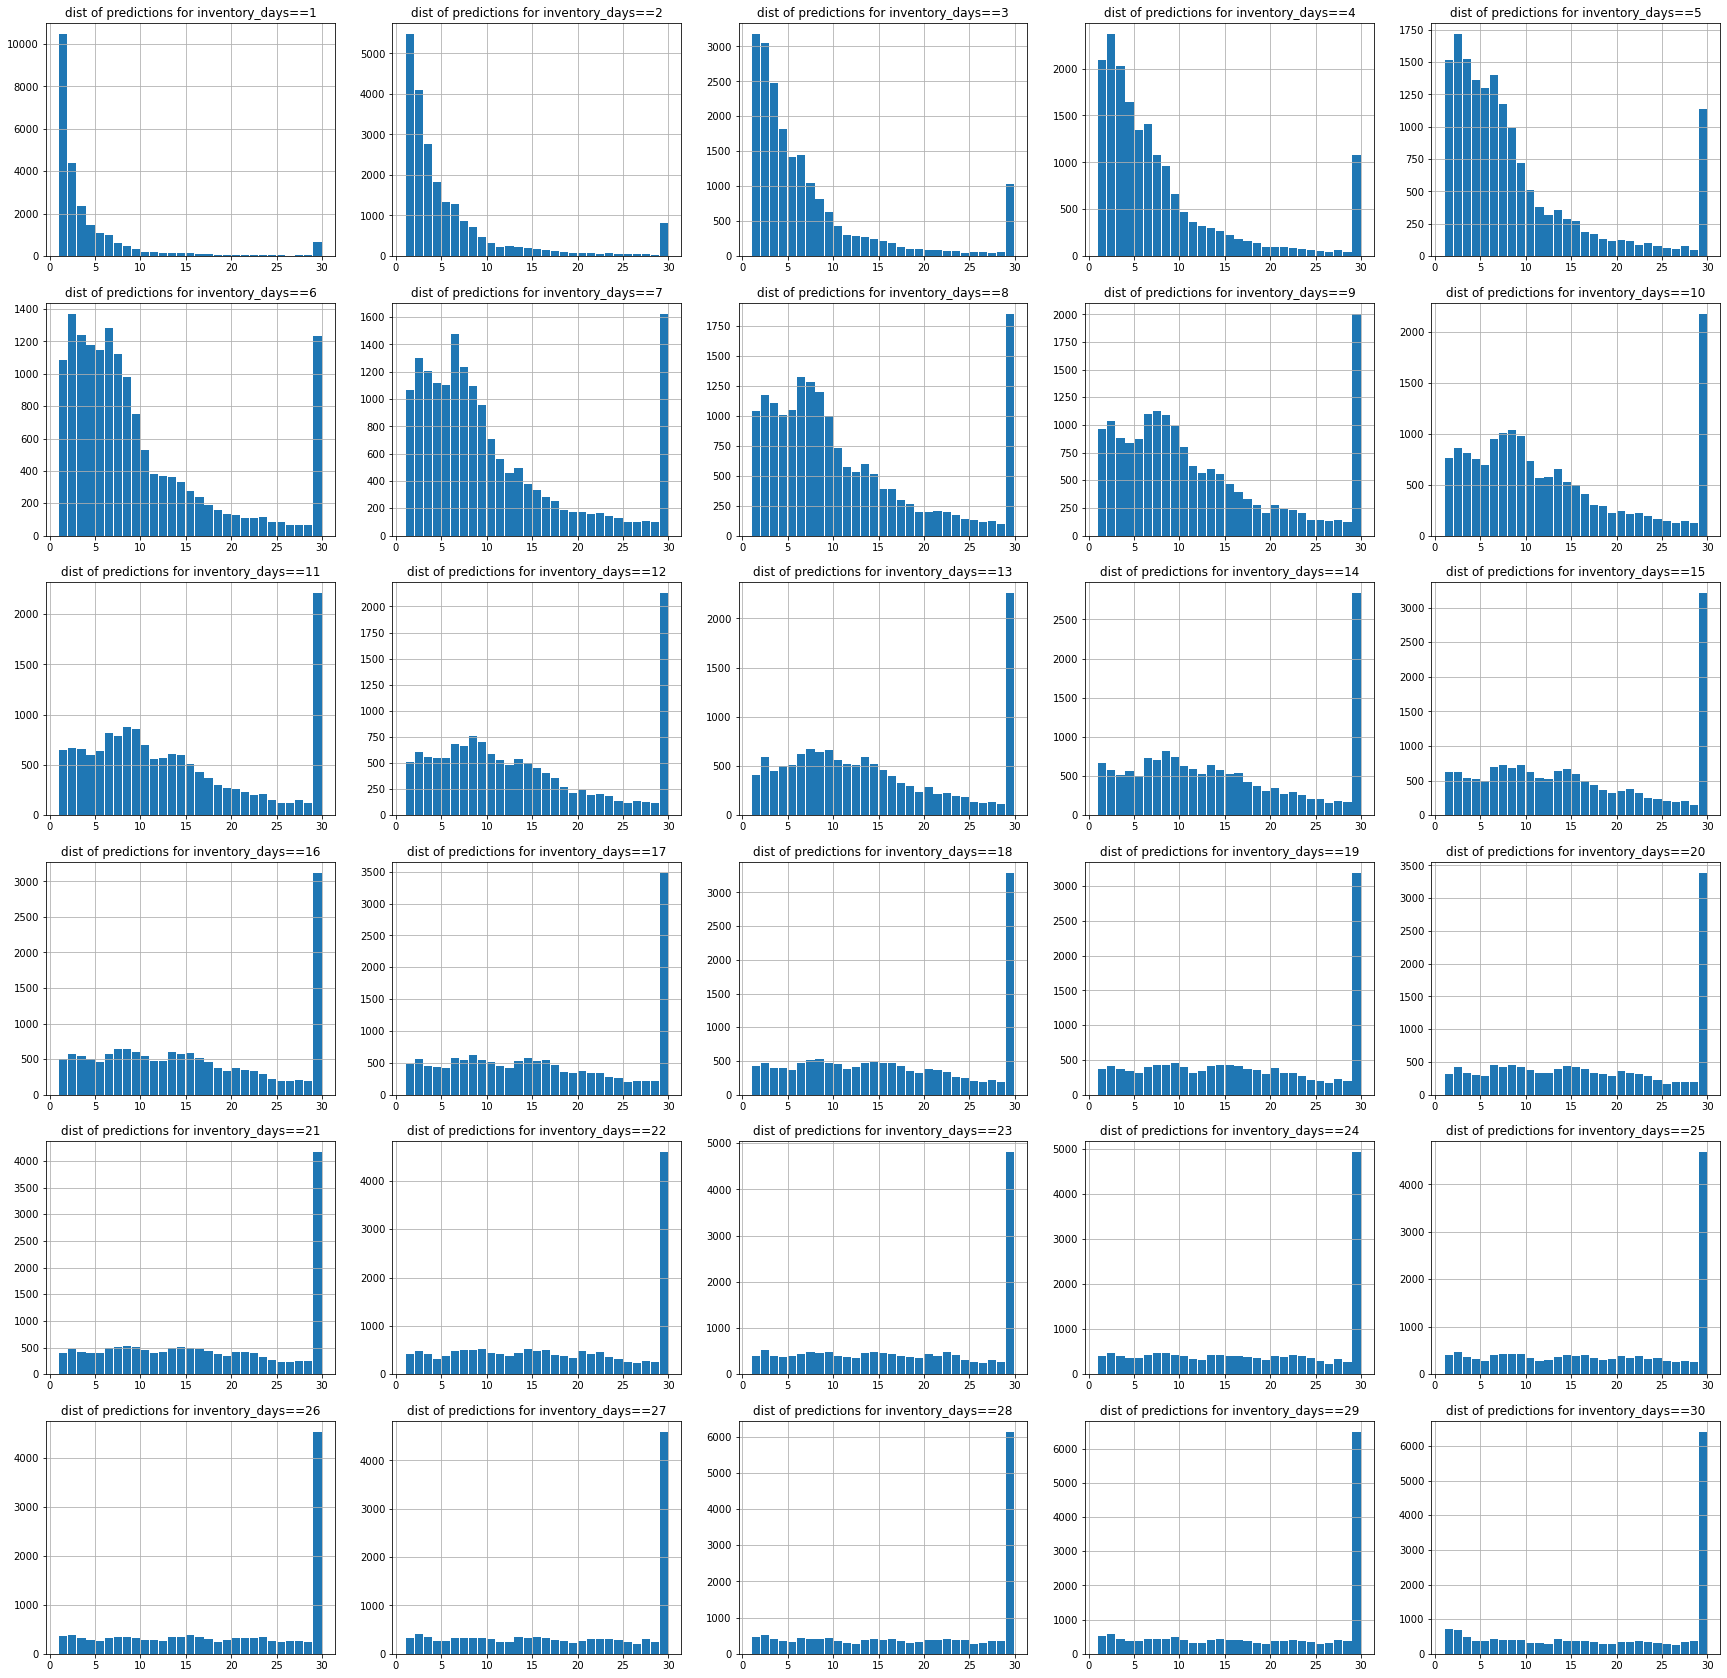

In [19]:
if ASSESS:
    print("RMSE (mean): ", np.sqrt(valid.query("inventory_days <= 31").eval("(days_to_stockout - inventory_days)**2").mean()) )
    print("MAE (mean): ",  valid.query("inventory_days <= 31").eval("abs(days_to_stockout - inventory_days)").mean() )
    print("MAE (median): ", valid.query("inventory_days <= 31").eval("abs(days_to_stockout - inventory_days)").median() )
    print()
    
    plt.figure(figsize=(20,5))
    plt.hist(
        [valid.query("inventory_days <= 31").inventory_days, 
         valid.query("inventory_days <= 31").days_to_stockout,
        ],
        label=["target","predictions"],
        bins=np.arange(1,31,1),
        align="right",
        rwidth=0.8)
    plt.legend(loc="best")
    plt.grid()
    plt.show()
    print()
    
    plt.figure(figsize=(30,30))
    for d in range(1,31):
        plt.subplot(6, 5, d)
        plt.hist(valid.query("days_to_stockout_disc==@d").inventory_days, bins=np.arange(1,31,1), rwidth=0.9)
        plt.title(f"dist of targets for days_to_stockout_disc=={d}")
        plt.grid()
    plt.show()
    print()
    
    plt.figure(figsize=(30,30))
    for d in range(1,31):
        plt.subplot(6, 5, d)
        plt.hist(valid.query("inventory_days==@d").days_to_stockout, bins=np.arange(1,31,1), rwidth=0.9)
        plt.title(f"dist of predictions for inventory_days=={d}")
        plt.grid()
    plt.show()

RMSE (mean):  9.205187823333494
MAE (mean):  6.865894470002798
MAE (median):  5.0



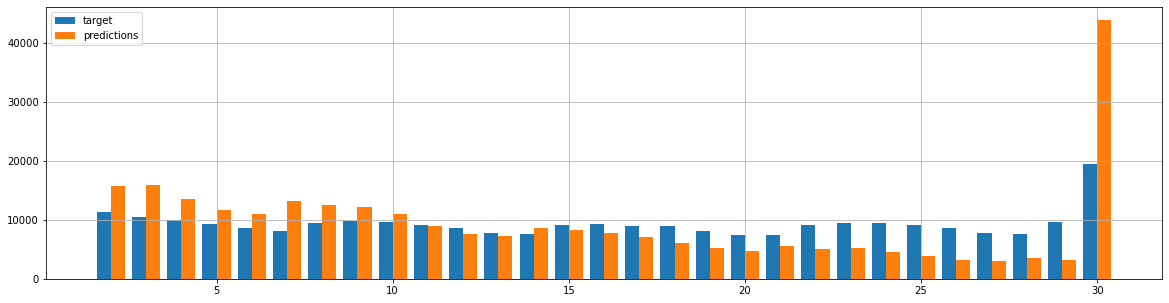

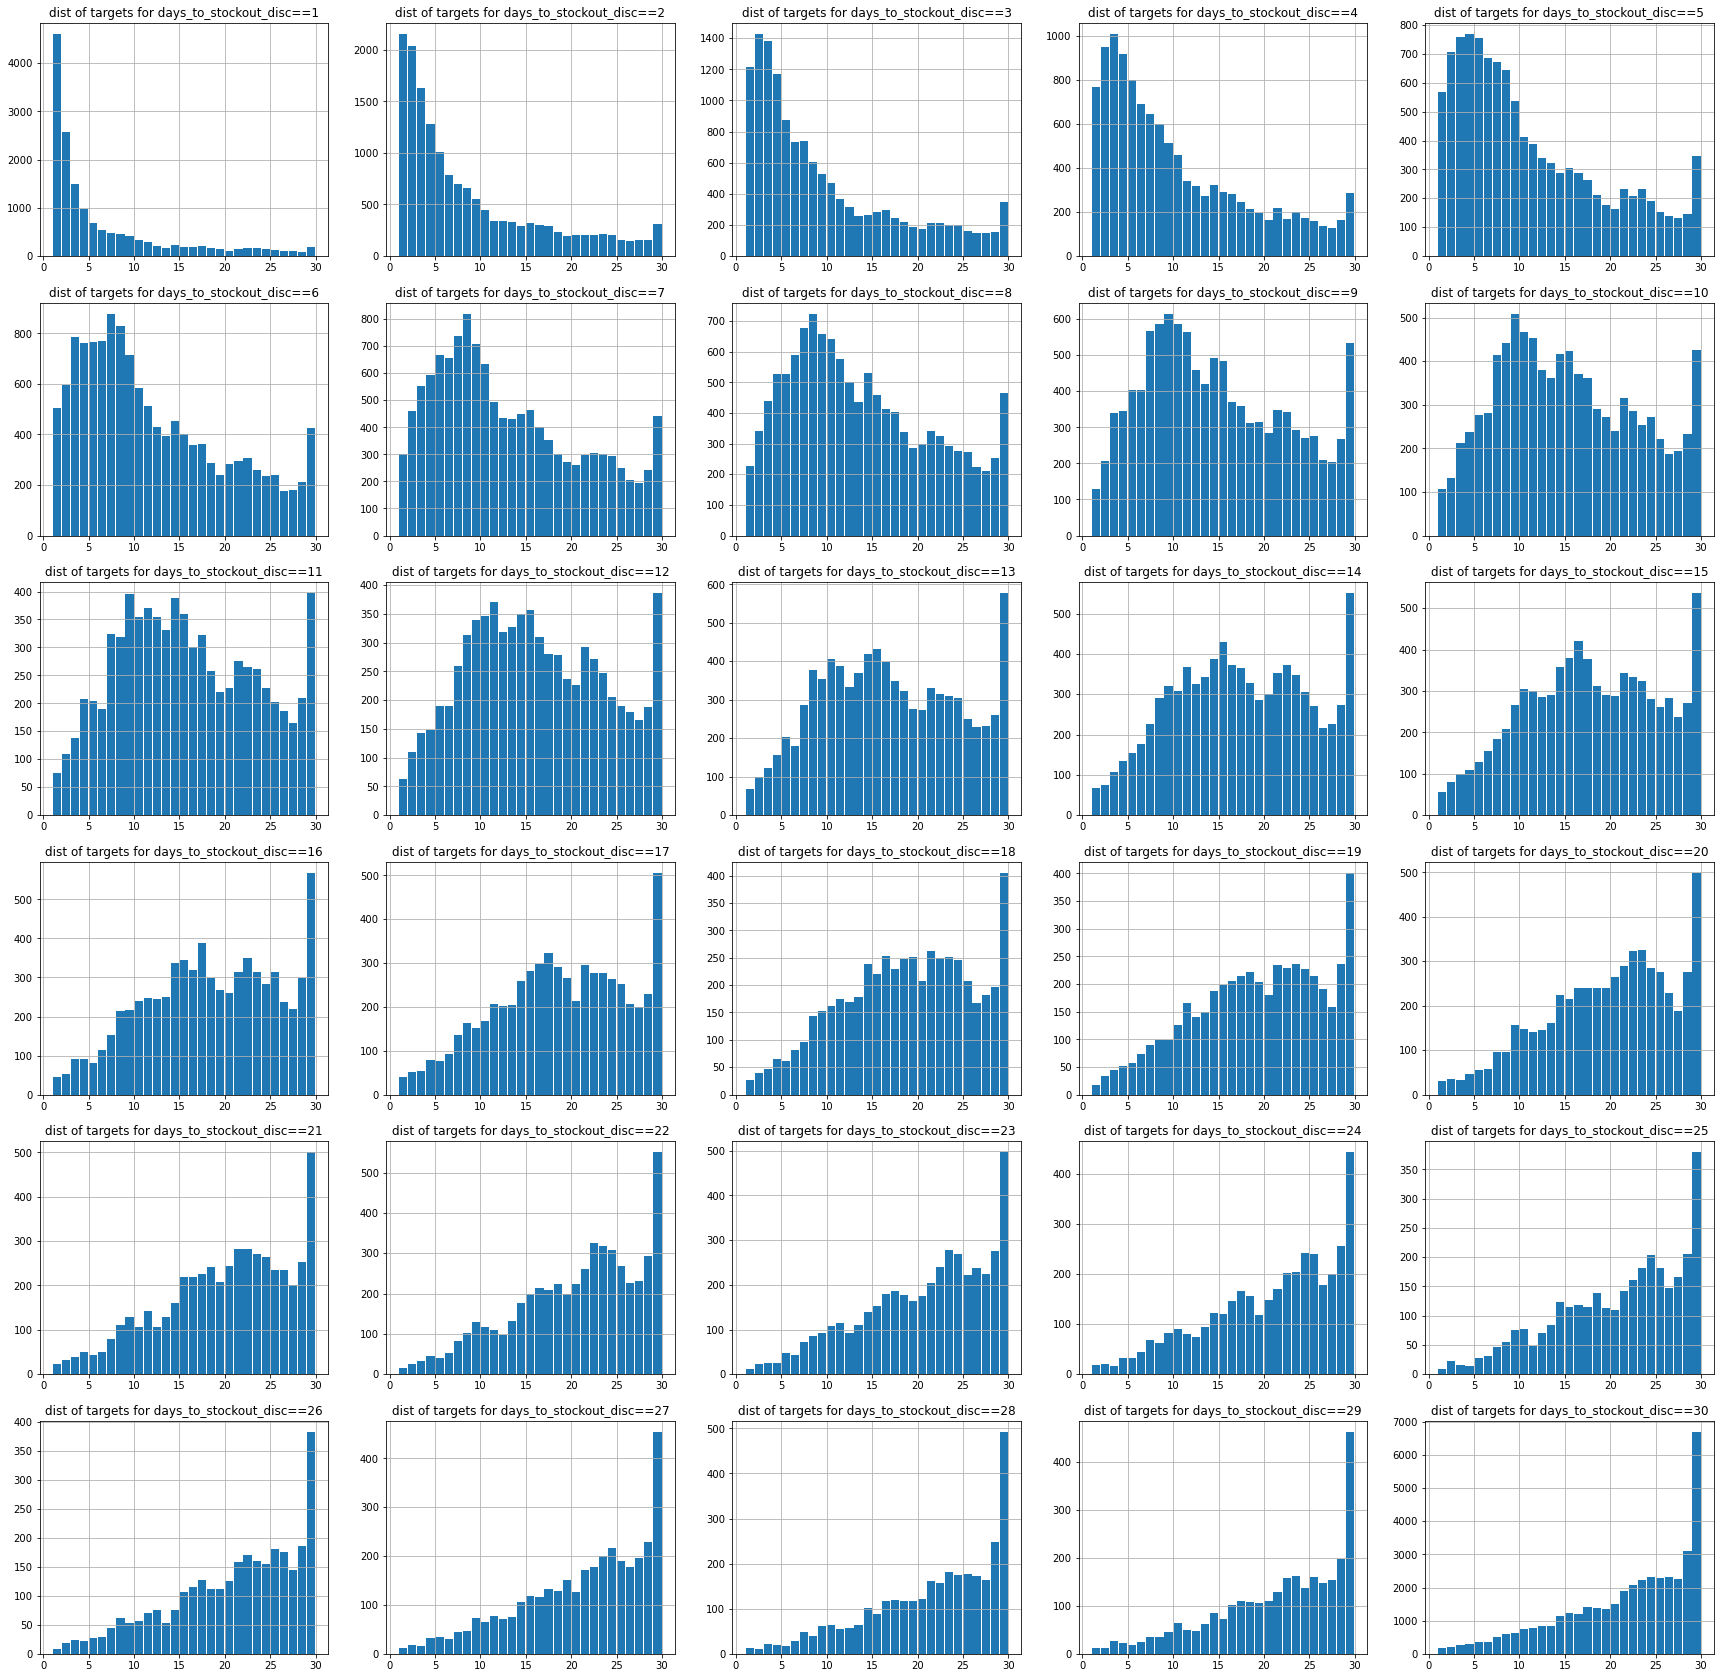

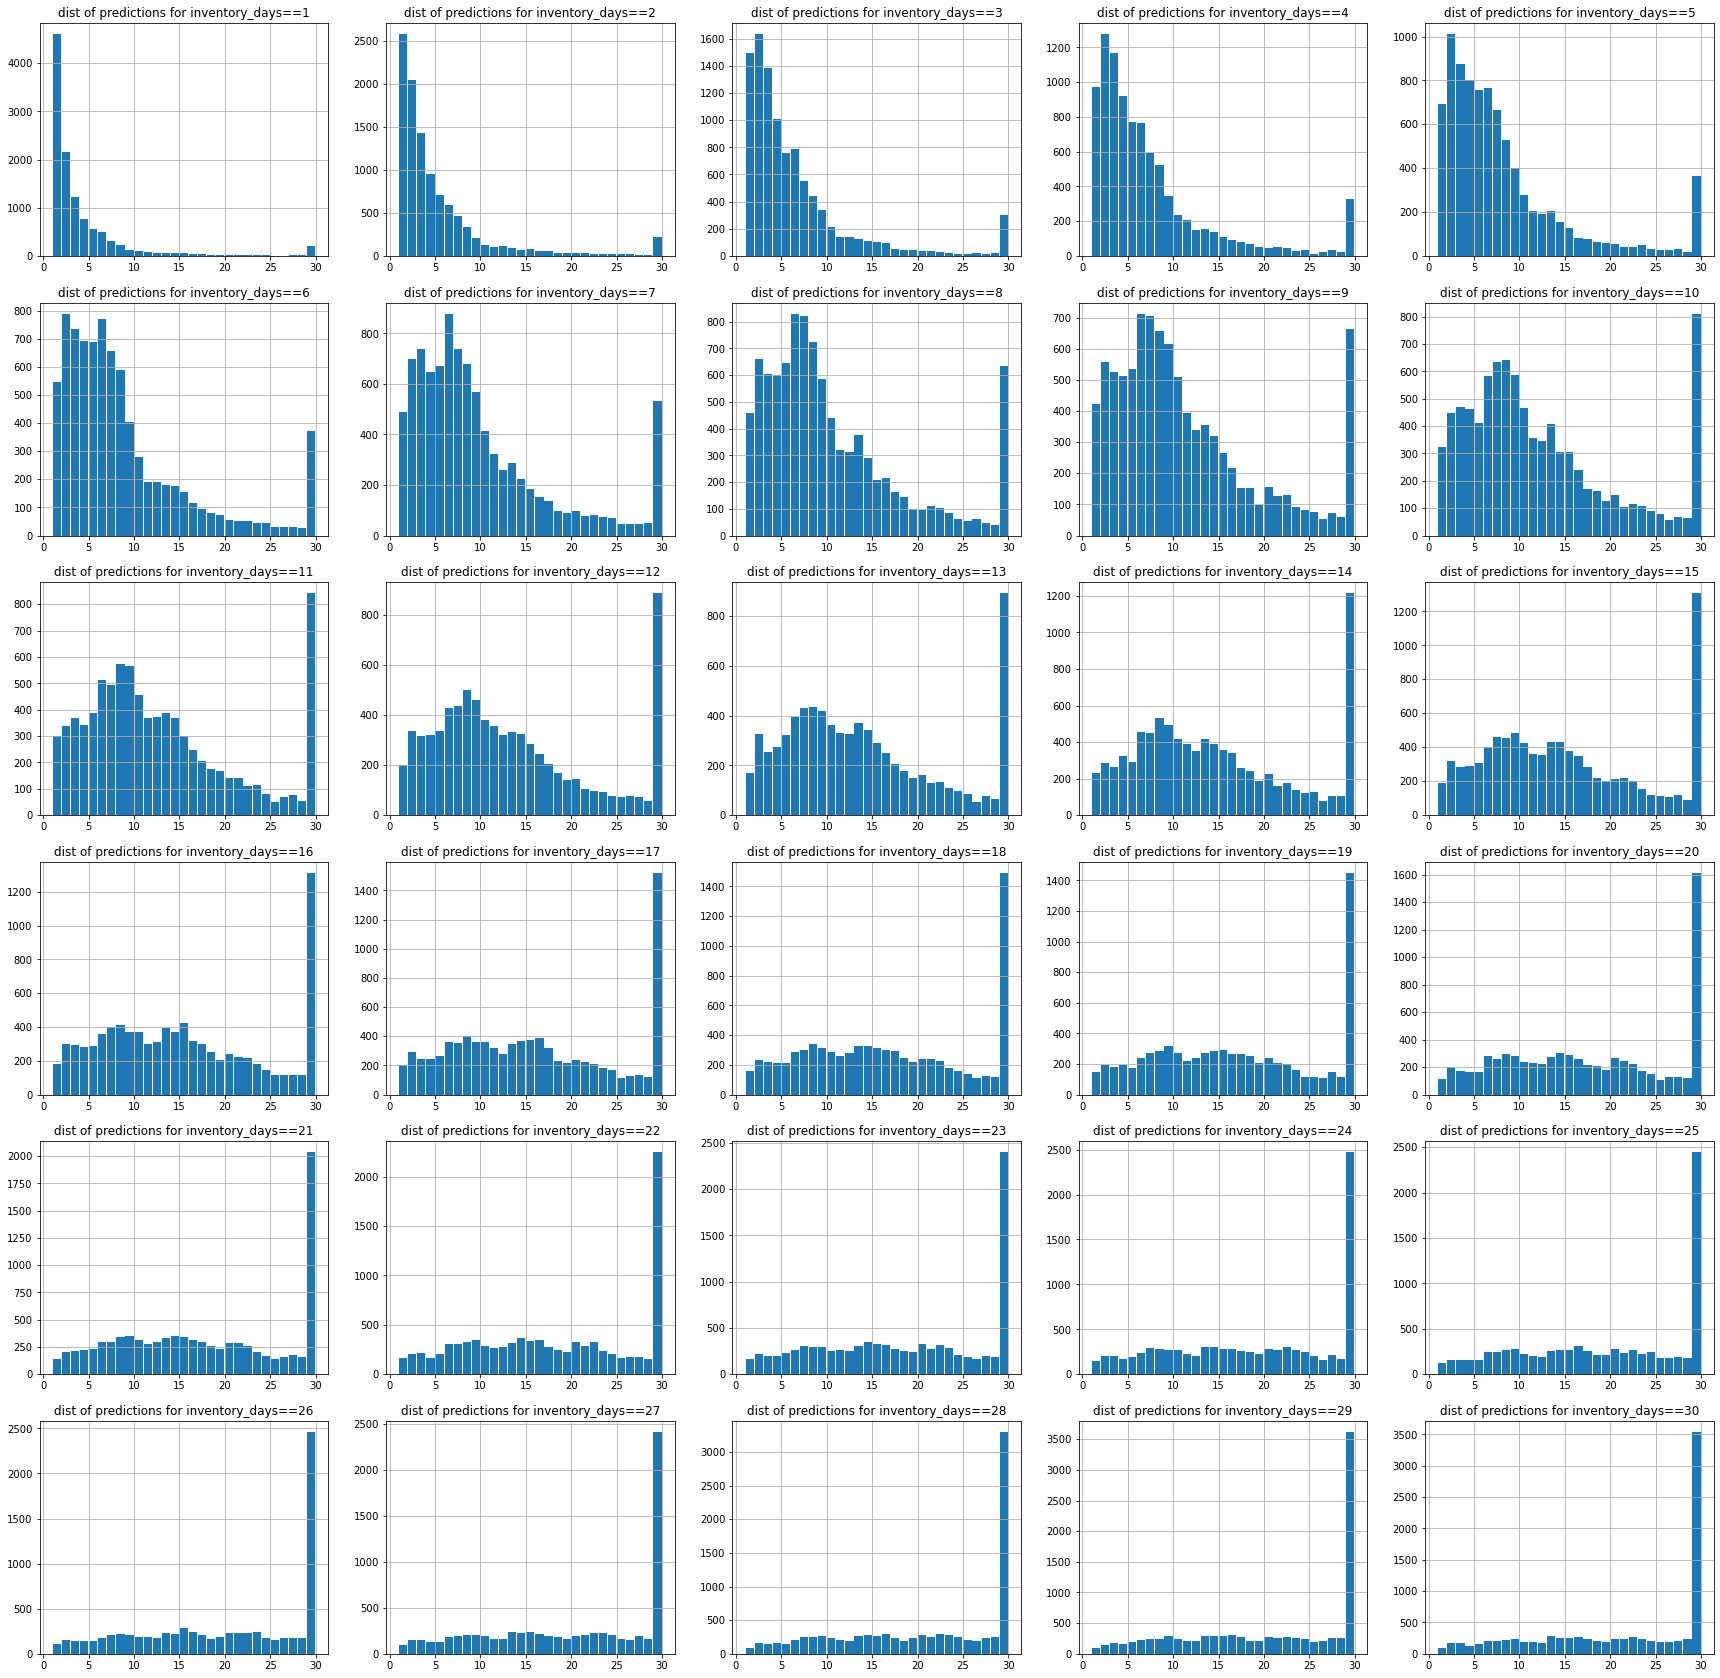

In [20]:
if ASSESS:
    print("RMSE (mean): ", np.sqrt(valid.query("sku in @skus_assess_m2").eval("(days_to_stockout - inventory_days)**2").mean()) )
    print("MAE (mean): ",  valid.query("sku in @skus_assess_m2").eval("abs(days_to_stockout - inventory_days)").mean() )
    print("MAE (median): ", valid.query("sku in @skus_assess_m2").eval("abs(days_to_stockout - inventory_days)").median() )
    print()
    
    plt.figure(figsize=(20,5))
    plt.hist(
        [valid.query("sku in @skus_assess_m2").inventory_days, 
         valid.query("sku in @skus_assess_m2").days_to_stockout,
        ],
        label=["target","predictions"],
        bins=np.arange(1,31,1),
        align="right",
        rwidth=0.8)
    plt.legend(loc="best")
    plt.grid()
    plt.show()
    print()
    
    plt.figure(figsize=(30,30))
    for d in range(1,31):
        plt.subplot(6, 5, d)
        plt.hist(valid.query("(days_to_stockout_disc == @d) & (sku in @skus_assess_m2)").inventory_days, bins=np.arange(1,31,1), rwidth=0.9)
        plt.title(f"dist of targets for days_to_stockout_disc=={d}")
        plt.grid()
    plt.show()
    print()
    
    plt.figure(figsize=(30,30))
    for d in range(1,31):
        plt.subplot(6, 5, d)
        plt.hist(valid.query("(inventory_days == @d) & (sku in @skus_assess_m2)").days_to_stockout, bins=np.arange(1,31,1), rwidth=0.9)
        plt.title(f"dist of predictions for inventory_days=={d}")
        plt.grid()
    plt.show()

***
## Assessment of RPS

In [21]:
if ASSESS:
    valid_files = [fn for fn in glob(f"{input_path}/validation_*.csv") if "seed2.csv" not in fn]
    results = list()

    for files in valid_files:
        valid = (
            pd.read_csv(files)
            .query("sku in @skus_assess_m1")
            .query("inventory_days <= 30")
            .reset_index(drop=True)
        )
        valid["inventory_days"] = valid["inventory_days"].astype(int)
        
        preds_proba = list()
        for sku,df in tqdm(valid.groupby("sku")):
            preds_proba.append(predictor.predict_proba(
                sku, 
                stock=df.target_stock.values[0],
                dist_kwargs={"beta":dist_config["beta"]},
                lambda1=dist_config["lambda1"], 
                lambda2=dist_config["lambda2"],
            ))
        preds_proba = np.array(preds_proba)

        rps = scoring_function(valid.inventory_days.values, preds_proba)
        results.append({"file":files.split("/")[-1].split(".")[0], "rps":rps})
        print({"file":files.split("/")[-1].split(".")[0], "rps":rps})

100%|██████████| 482635/482635 [02:21<00:00, 3420.11it/s]


{'file': 'validation_seed17', 'rps': 4.2817074405176365}


100%|██████████| 482635/482635 [02:21<00:00, 3405.22it/s]


{'file': 'validation_seed23_harder', 'rps': 4.534927158493193}


100%|██████████| 482635/482635 [02:21<00:00, 3417.29it/s]


{'file': 'validation_seed2_harder', 'rps': 4.532906768100428}


100%|██████████| 482635/482635 [02:20<00:00, 3426.33it/s]


{'file': 'validation_seed19_harder', 'rps': 4.534327924526725}


100%|██████████| 482635/482635 [02:20<00:00, 3442.44it/s]


{'file': 'validation_seed19', 'rps': 4.2796857776577815}


100%|██████████| 482635/482635 [02:20<00:00, 3434.57it/s]


{'file': 'validation_seed23', 'rps': 4.2793791064443125}


100%|██████████| 482635/482635 [02:20<00:00, 3428.93it/s]


{'file': 'validation_seed17_harder', 'rps': 4.533521670030459}


100%|██████████| 324347/324347 [01:34<00:00, 3433.27it/s]


{'file': 'validation_realstock', 'rps': 3.938500014962413}


In [22]:
if ASSESS:
    display(pd.DataFrame(results))
    
    # cleanup ram
    del models_by_site
    gc.collect()

,file,rps
0,validation_seed17,4.281707
1,validation_seed23_harder,4.534927
2,validation_seed2_harder,4.532907
3,validation_seed19_harder,4.534328
4,validation_seed19,4.279686
5,validation_seed23,4.279379
6,validation_seed17_harder,4.533522
7,validation_realstock,3.938500


***
## model training

In [12]:
unpredictable = pd.read_csv(f"{input_path}/unpredictable.csv")
skus_for_test = pd.read_csv(f"{input_path}/test_data.csv").sku.values

dataset = (
    pd.read_parquet(f"{input_path}/train-m1.parquet")
    .query("sku not in @unpredictable.sku")
    .query("sku in @skus_for_test")
    .rename({"date":"ds", "sold_quantity":"y"}, axis=1,)
    .sort_values(["sku","ds"])
    .reset_index(drop=True)
)
print("nrows:", len(dataset)/1e6)
print("nskus:", dataset.sku.nunique())

with open("../encoders/encoder-stg2.dill", "rb") as file:
    encoder = dill.load(file)
    file.close()

transformed = encoder.transform(dataset[encoder.cols].astype("category"))
for col in transformed.columns:
    dataset[col+"_glm"] = transformed[col].values

nrows: 30.218397
nskus: 526158


In [13]:
test = (
    pd.read_parquet(f"{input_path}/test-m1.parquet")
    .query("sku not in @unpredictable.sku")
    .rename({"date":"ds",}, axis=1,)
    .sort_values(["sku","ds"])
    .reset_index(drop=True)
)
print("nrows:", len(test)/1e6)
print("nskus:", test.sku.nunique())

transformed = encoder.transform(test[encoder.cols].astype("category"))
for col in transformed.columns:
    test[col+"_glm"] = transformed[col].values

nrows: 15.78474
nskus: 526158


In [14]:
raw = pd.read_parquet(f"{input_path}/train_data.parquet", columns=["sku", "date", "sold_quantity", "minutes_active"])
metadata = pd.read_csv(f"{input_path}/metadata.csv", usecols=["sku","item_domain_id","site_id"])
raw = pd.merge(raw, metadata, how="inner", on="sku")

# compute q_mean and q_std features (w/o leakage)
feat = Featurador(raw)
feat.fit(left_limit="2021-02-01", right_limit="2021-03-31")
dataset = feat.transform(dataset)
test = feat.transform(test)

------------------------------------------------------------------------------------------
Preparing model for site: MLA
Mem. usage decreased to 280.06 Mb (50.9% reduction)
Elapsed time for processing features: 0.6325961947441101 min.
[LightGBM] [Info] Total Bins 11078
[LightGBM] [Info] Number of data points in the train set: 2621973, number of used features: 23


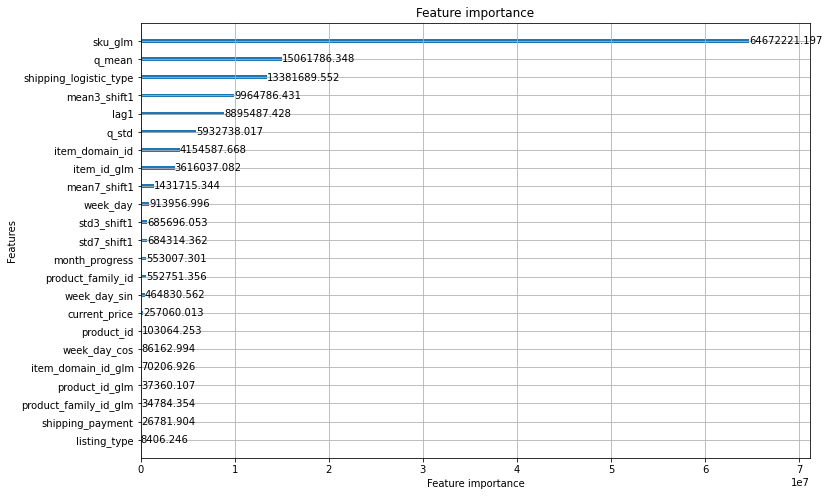

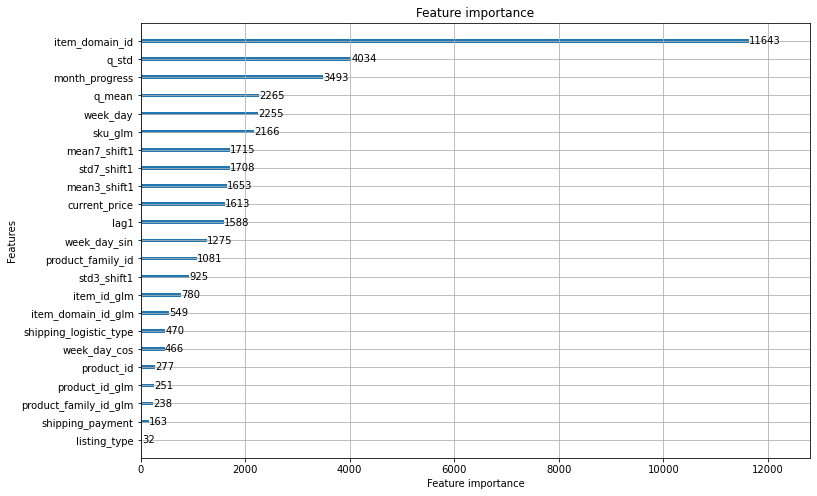

Elapsed time for training the model: 0.41197272539138796 min.
------------------------------------------------------------------------------------------
Preparing model for site: MLB
Mem. usage decreased to 1682.55 Mb (50.0% reduction)
Elapsed time for processing features: 3.5415958921114603 min.
[LightGBM] [Info] Total Bins 18047
[LightGBM] [Info] Number of data points in the train set: 15476171, number of used features: 23


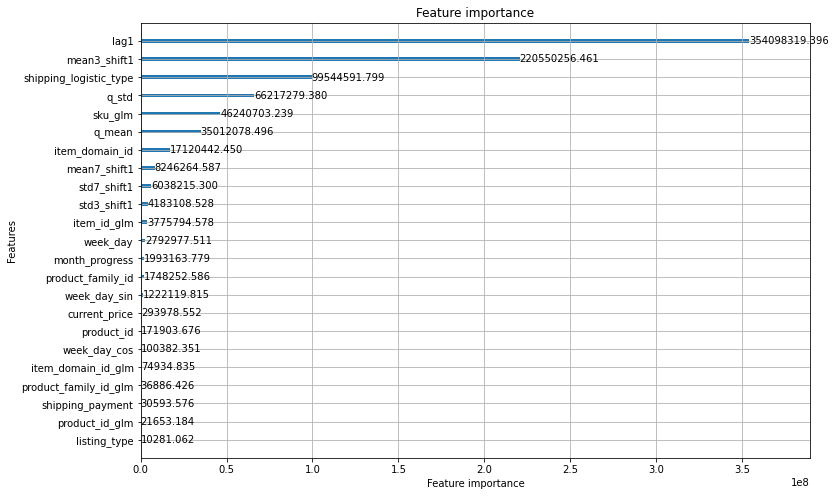

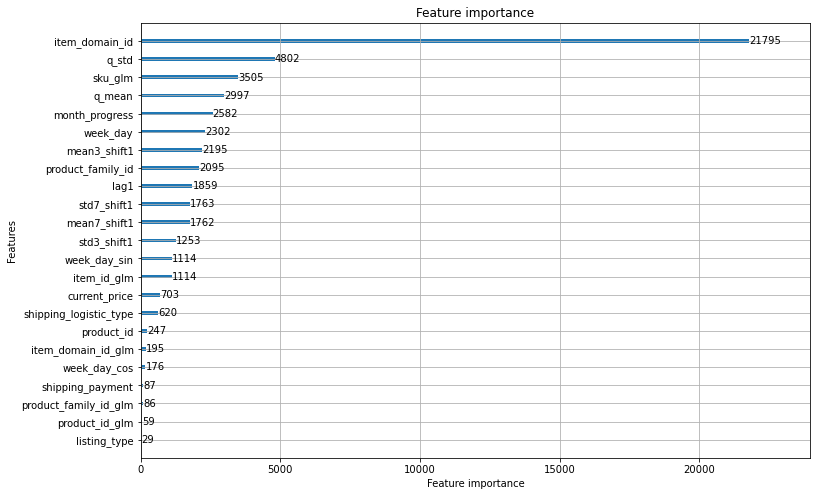

Elapsed time for training the model: 2.2398424545923867 min.
------------------------------------------------------------------------------------------
Preparing model for site: MLM
Mem. usage decreased to 1294.58 Mb (50.9% reduction)
Elapsed time for processing features: 2.7906101902325946 min.
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Info] Total Bins 15613
[LightGBM] [Info] Number of data points in the train set: 12120253, number of used features: 23


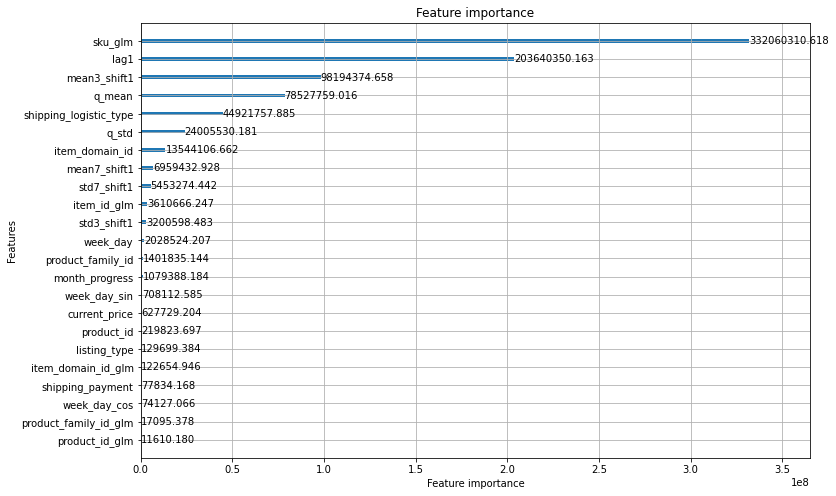

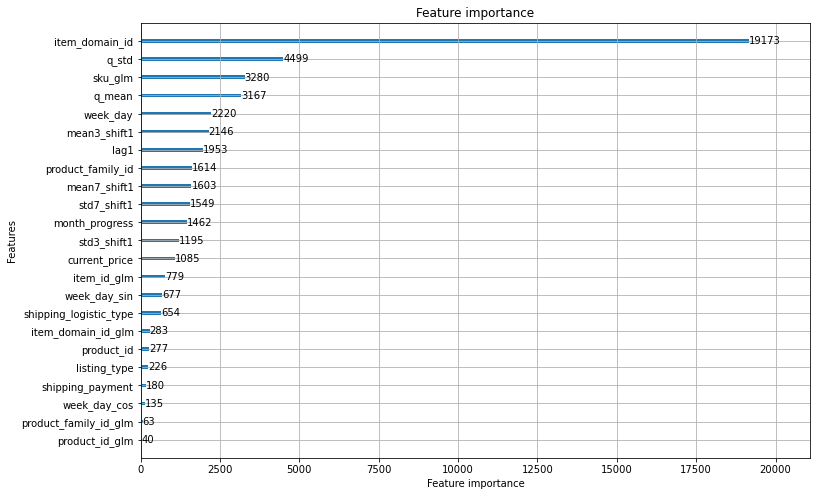

Elapsed time for training the model: 1.8537469267845155 min.


In [15]:
models_by_site = list()
sites = [
    "MLA",
    "MLB",
    "MLM",
]
num_iterations = {
    "MLA": 160,
    "MLB": 210,
    "MLM": 190,
}

for site in sites:
    print("-"*90)
    print(f"Preparing model for site: {site}")

    tic = time.time()
    train_data = dataset.query("site_id == @site").reset_index(drop=True)
    
    _model_kwargs = dict(model_kwargs)
    _model_kwargs["model_params"]["num_iterations"] = num_iterations[site]

    model = LightGBMForecaster(**_model_kwargs)
    model.prepare_features(train_data)
    model.train_features = reduce_mem_usage(model.train_features, verbose=True)
    gc.collect()
    tac = time.time()
    print(f"Elapsed time for processing features: {(tac-tic)/60} min.")

    tic = time.time()
    model.fit()
    lgb.plot_importance(model.model.model, figsize=(12,8), importance_type="gain")
    lgb.plot_importance(model.model.model, figsize=(12,8), importance_type="split")
    plt.show()
    models_by_site.append(model)
    tac = time.time()
    print(f"Elapsed time for training the model: {(tac-tic)/60} min.")


In [16]:
# calculates fit stats on train dataset
all_preds = list()
for site,model in zip(sites,models_by_site):
    preds = model.predict(dataset.query("site_id==@site"))
    all_preds.append(preds)
train_preds = pd.concat(all_preds, axis=0, ignore_index=True)
train_preds = pd.merge(train_preds, dataset.loc[:,["ds","sku","site_id","y"]], how="inner", on=["ds","sku"])

train_preds["abs_error"] = train_preds.eval("abs(y-y_pred)")
train_preds["sq_error"] = train_preds.eval("(y-y_pred)**2")
train_preds["residual"] = train_preds.eval("(y-y_pred)")

rmse = np.sqrt(train_preds.groupby(["sku"])["sq_error"].mean()).reset_index(name="rmse")
mean_ae = train_preds.groupby(["sku"])["abs_error"].mean().reset_index(name="mean_ae")
median_ae = train_preds.groupby(["sku"])["abs_error"].median().reset_index(name="median_ae")
residual_std = train_preds.groupby(["sku"])["residual"].std().reset_index(name="residual_std")
residual_mad = train_preds.groupby(["sku"])["residual"].mad().reset_index(name="residual_mad")

fit_stats = (
    rmse
    .merge(mean_ae, how="inner", on="sku")
    .merge(median_ae, how="inner", on="sku")
    .merge(residual_std, how="inner", on="sku")
    .merge(residual_mad, how="inner", on="sku")
    .merge(scales, how="inner", on="sku")
    .merge(dataset[["sku","site_id","q_mean"]].drop_duplicates(subset=["sku"]), how="inner", on="sku")
)
fit_stats["rmsse"] = fit_stats.eval("rmse / scale")
fit_stats["rmse_norm"] = fit_stats.eval("rmse / q_mean")
fit_stats["mean_ae_norm"] = fit_stats.eval("mean_ae / q_mean")
fit_stats["median_ae_norm"] = fit_stats.eval("median_ae / q_mean")
fit_stats["residual_std_norm"] = fit_stats.eval("residual_std / q_mean")
fit_stats["residual_mad_norm"] = fit_stats.eval("residual_mad / q_mean")
fit_stats["scale_norm"] = fit_stats.eval("scale / q_mean")
display(fit_stats.groupby("site_id")["rmsse"].mean())

fit_stats.to_csv(f"{results_path}/train_errors_lgbm-m1-stg2.csv", index=False)

site_id
MLA    0.797561
MLB    0.842651
MLM    0.842271
Name: rmsse, dtype: float64

In [17]:
# compute predictions on test period
preds_by_site = list()

for site,model in tqdm(zip(sites,models_by_site)):
    preds = model.predict(test.query("site_id == @site"), recursive=True)
    preds_by_site.append(preds)
    
predictions = pd.concat(preds_by_site, ignore_index=True)
predictions.to_csv(f"../results/preds_m1_lgbm_sub{SUB_NBR}.csv", index=False)

3it [30:16, 605.49s/it]


In [18]:
predictor = InventoryDaysPredictor(dataset)
predictor.fit(predictions)

100%|██████████| 526158/526158 [01:22<00:00, 6407.36it/s]


100%|██████████| 526158/526158 [01:21<00:00, 6468.67it/s]


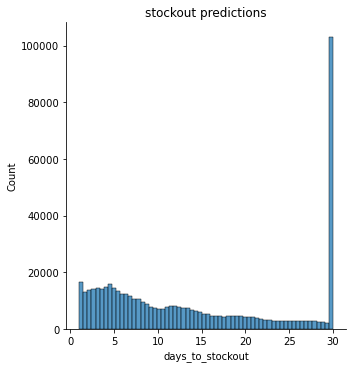

In [19]:
stockout_preds = list()
groups = (
    test[["sku","target_stock"]]
    .drop_duplicates()
    .groupby("sku")
)

for sku,df in tqdm(groups):
    stockout_preds.append(predictor.predict(sku, df.target_stock.values[0])[0])
stockout_preds = pd.DataFrame(stockout_preds, columns=["days_to_stockout"])


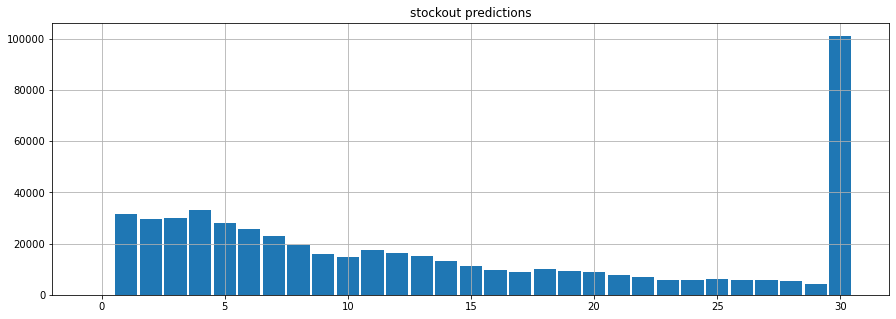

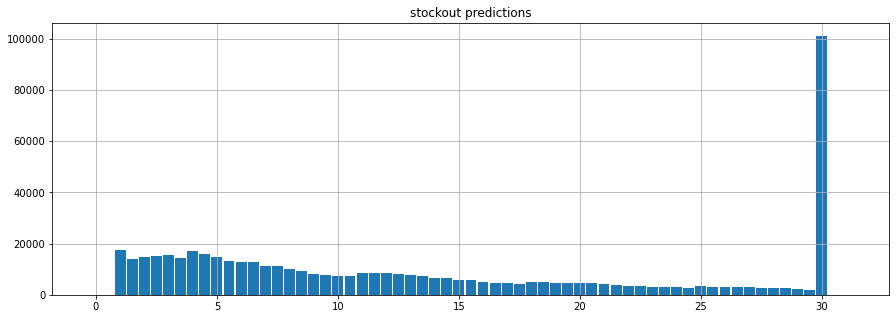

In [36]:
plt.figure(figsize=(15,5))
plt.hist(stockout_preds.days_to_stockout, bins=np.arange(0,32,1), rwidth=0.9, align='left')
plt.grid()
plt.title("stockout predictions")
plt.show()

plt.figure(figsize=(15,5))
plt.hist(stockout_preds.days_to_stockout, bins=np.arange(0,32,0.5), rwidth=0.9, align='left')
plt.grid()
plt.title("stockout predictions")
plt.show()

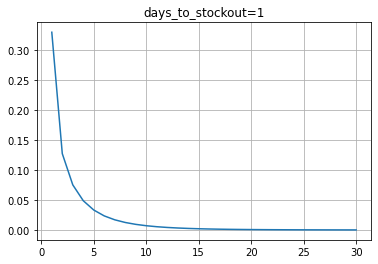

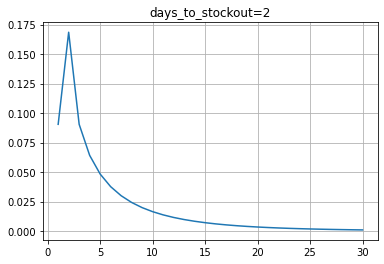

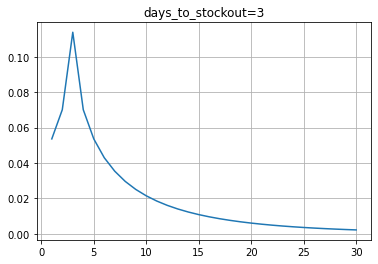

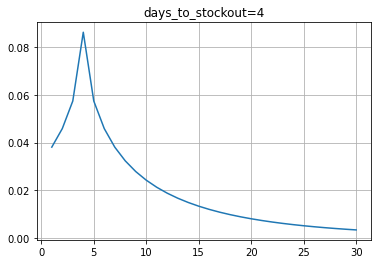

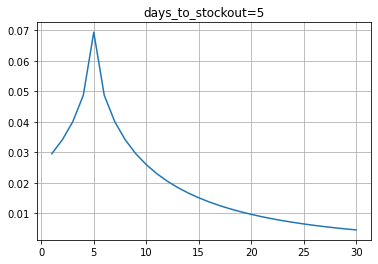

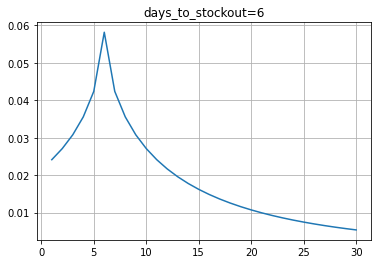

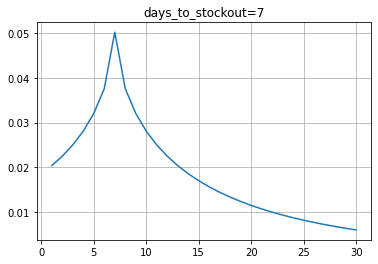

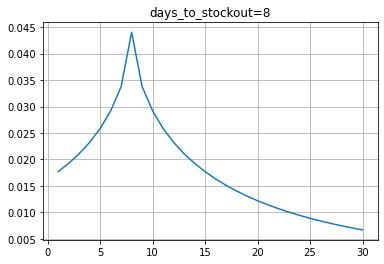

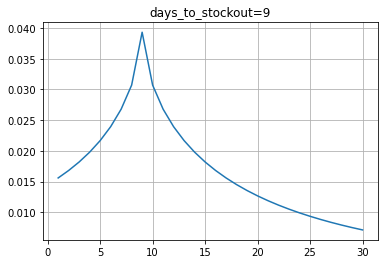

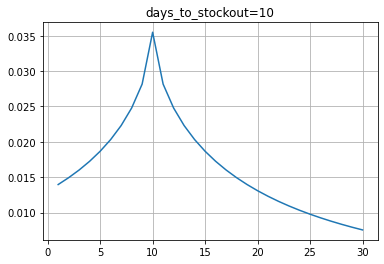

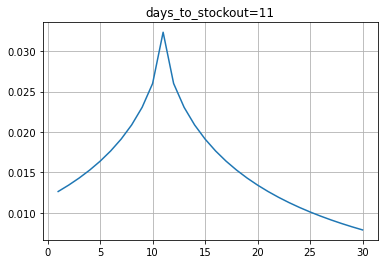

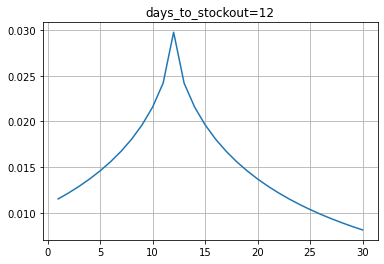

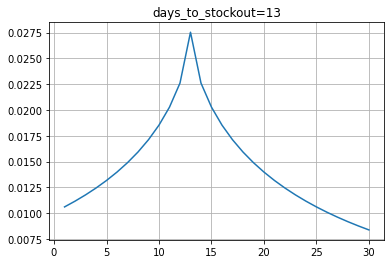

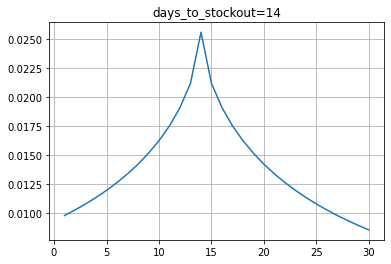

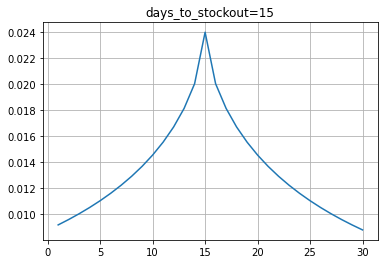

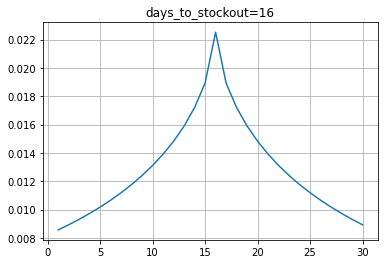

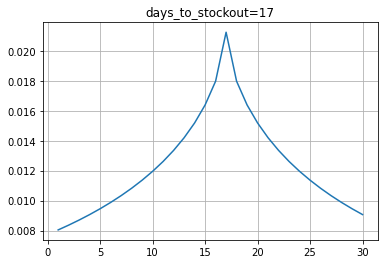

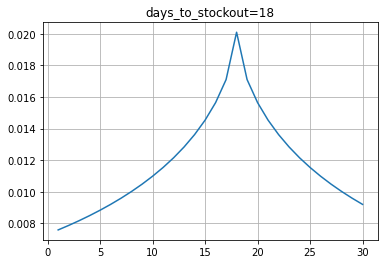

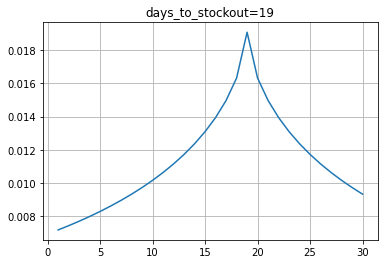

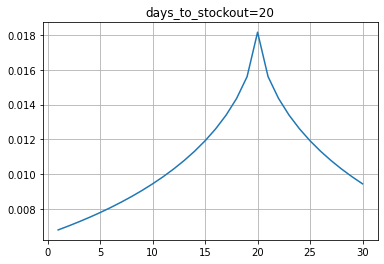

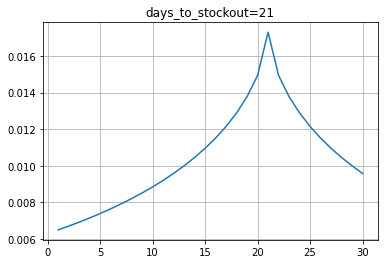

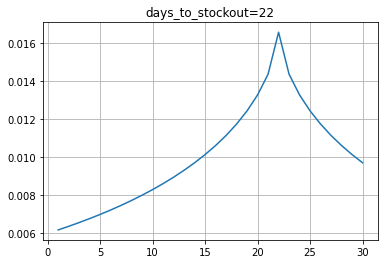

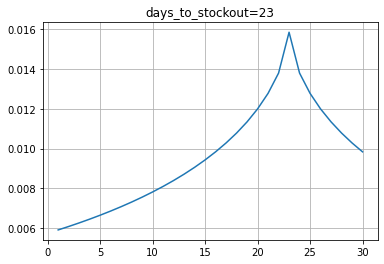

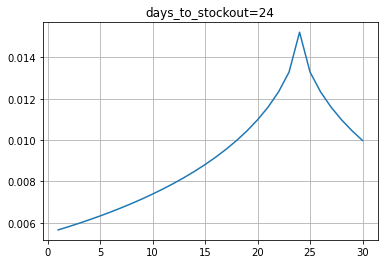

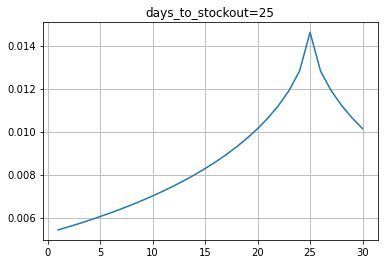

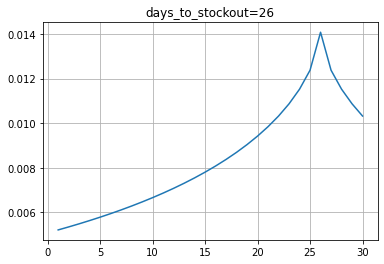

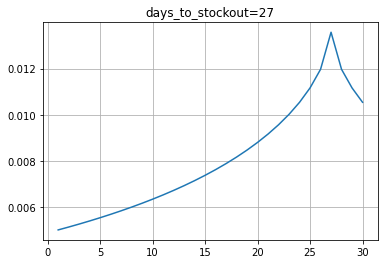

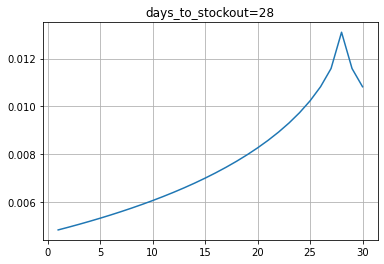

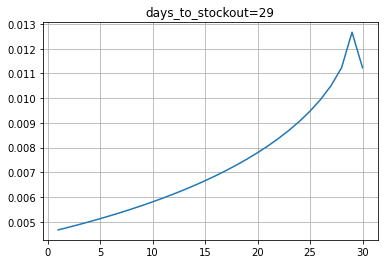

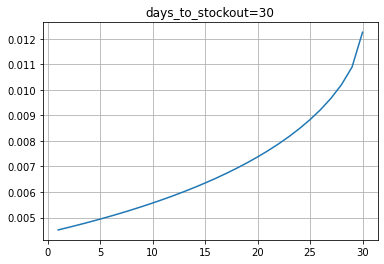

In [20]:
std_days = np.mean(np.asarray(list(predictor.parameters["std"].values())) / np.asarray(list(predictor.parameters["mean"].values())))

for days_to_stockout in range(1,31):
    scale = std_days * (dist_config["lambda1"]*(days_to_stockout**dist_config["lambda2"]))
    days = np.arange(1,31)
    probs = stats.gennorm.pdf(days, loc=days_to_stockout, scale=scale, beta=dist_config["beta"])
    
    plt.plot(days, probs)
    plt.grid()
    plt.title(f"days_to_stockout={days_to_stockout}")
    plt.show()

In [21]:
skus = list()
preds_proba = list()
groups = (
    test[["sku","target_stock"]]
    .drop_duplicates()
    .groupby("sku")
)

for sku,df in tqdm(groups):
    skus.append(sku)
    preds_proba.append(predictor.predict_proba(
        sku, 
        stock=df.target_stock.values[0],
        dist_kwargs={"beta":dist_config["beta"]},
        lambda1=dist_config["lambda1"], 
        lambda2=dist_config["lambda2"],
    ))
preds_proba = np.array(preds_proba)
preds_proba = pd.DataFrame(preds_proba, index=skus)

100%|██████████| 526158/526158 [02:43<00:00, 3220.13it/s]


In [22]:
unpreds_proba = np.ones((len(unpredictable),30)) / 30
unpreds_proba = pd.DataFrame(unpreds_proba, index=unpredictable.sku.values)

preds_proba_mrg = pd.concat([preds_proba, unpreds_proba])
preds_proba_mrg

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29
0,0.077514,0.096631,0.124316,0.090917,0.073936,0.062214,0.053378,0.046403,0.040733,0.036028,0.032064,0.028683,0.025771,0.023243,0.021033,0.019090,0.017373,0.015848,0.014489,0.013273,0.012182,0.011199,0.010312,0.009510,0.008782,0.008121,0.007518,0.006969,0.006466,0.006006
1,0.020284,0.021058,0.021880,0.022755,0.023687,0.024684,0.025753,0.026904,0.028148,0.029500,0.030978,0.032604,0.034412,0.036445,0.038771,0.041496,0.044825,0.049254,0.056277,0.048629,0.044383,0.041143,0.038473,0.036188,0.034185,0.032401,0.030793,0.029332,0.027994,0.026761
2,0.025573,0.025934,0.026305,0.026686,0.027078,0.027482,0.027898,0.028328,0.028771,0.029229,0.029704,0.030195,0.030705,0.031235,0.031786,0.032362,0.032963,0.033593,0.034256,0.034954,0.035694,0.036481,0.037323,0.038232,0.039222,0.040317,0.041554,0.043000,0.044822,0.048319
3,0.027775,0.029521,0.031462,0.033638,0.036105,0.038944,0.042282,0.046334,0.051548,0.059341,0.058747,0.051202,0.046076,0.042073,0.038769,0.035954,0.033506,0.031345,0.029416,0.027680,0.026106,0.024671,0.023356,0.022146,0.021029,0.019993,0.019031,0.018135,0.017298,0.016516
5,0.020408,0.020923,0.021458,0.022016,0.022597,0.023202,0.023835,0.024496,0.025188,0.025914,0.026676,0.027477,0.028322,0.029215,0.030160,0.031164,0.032233,0.033377,0.034606,0.035933,0.037376,0.038958,0.040711,0.042683,0.044948,0.047645,0.051088,0.056758,0.052191,0.048441
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
458740,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333
327670,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333
393209,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333
393212,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333


***
## generate submission

In [23]:
test = pd.read_csv(f"{input_path}/test_data.csv")
preds_proba_mrg = preds_proba_mrg.loc[test.sku.values,:].copy()

In [24]:
assert preds_proba_mrg.isna().sum(axis=1).sum() == 0
assert np.allclose(preds_proba_mrg.sum(axis=1).values, 1, atol=1e-16)
assert preds_proba_mrg.max(axis=1).max() < 1

In [25]:
(preds_proba_mrg
 .round(4)
 .to_csv(f"{subs_path}/sub{SUB_NBR}.csv.gz", header=False, index=False, compression="gzip")
)

***